# Read RadarSat2 data
Contrary to Sentinel1, RadarSat2 doesn't have the notion of multi dataset

In [ ]:
import xsar
import geoviews as gv
import holoviews as hv
import geoviews.feature as gf
hv.extension('bokeh')
path = xsar.get_test_file('RS2_OK135107_PK1187782_DK1151894_SCWA_20220407_182127_VV_VH_SGF')

## Access metadata from a product
Raw information is stocked in different files such as tiff ones (for digital numbers).
A file named product.xml is constitued of the main information (geolocation grid, orbit attitude, noise look up tables...).
Calibration look up tables are located in xml files.
All the useful data is grouped in a datatree thanks to dependencie `xradarsat2`.
This datatree is than used as an attribute of `RadarSat2Meta`.

In [ ]:
#Instanciate a RadarSat2Meta object
rs2meta = xsar.RadarSat2Meta(name=path)

In [ ]:
#Access the datatree extracted from the reader
rs2meta.dt

### Examples of alias to datasets (from the datatree above)

In [ ]:
#geolocation grid (low resolution)
rs2meta.geoloc

In [ ]:
#Calibration look up tables in range
rs2meta.lut

## Open a dataset

In [ ]:
# Define the resolution to load the dataset at a lower resolution (if not specified or None, the dataset is loaded at high resolution)
resolution = '1000m'

# Instanciate a RadarSatDataset object
rs2ds = xsar.RadarSat2Dataset(dataset_id=path, resolution=resolution)

### Get the Dataset object

In [ ]:
rs2ds

### Access the metadata object from the Dataset object

In [ ]:
rs2ds.rs2meta

### Access the dataset
In this dataset, we can find variables like latitude, longitude, look up tables (before and after denoising), incidence...

In [ ]:
rs2ds.dataset

Variables `lines_flipped`and `samples_flipped` are added to the dataset to know if these have been flipped (in order to follow xsar convention)

### Alternatives solutions to open dataset and datatree

In [ ]:
# Open dataset
xsar.open_dataset(path, resolution=resolution)

In [ ]:
# Open datatree
xsar.open_datatree(path, resolution=resolution)

## How to apply calibration?

All the operation below are already performed by default for GRD products. So, what is following is a simple explanation about how is made calibration.

### Load digital numbers 

`load_digital_number` is a function that allows to load digital numbers from tiff files at chosen resolution and return it as a `DataArray`. 
Resampling is made thanks to `rasterio.open(tiff_file).read`. 
For dual pol products, there is a tiff file for each pol. So that digital numbers are computed for both pol. Posting of lines and samples is computed thanks to `Affine.translation` and `Affine.scale`.

In [77]:
from xradarsat2 import load_digital_number
import rasterio

#Define resampling method (here it is the root mean square from rasterio)
resampling = rasterio.enums.Resampling.rms

#Define the chunks size for line and samples
chunks = {'line': 5000, 'sample': 5000}

In [78]:
dn_low_res = load_digital_number(rs2ds.rs2meta.dt, resolution=resolution, resampling=resampling, chunks=chunks)['digital_numbers'].ds
dn_low_res

<xarray.DatasetView>
Dimensions:         (pol: 2, line: 513, sample: 530)
Coordinates:
  * pol             (pol) <U2 'VV' 'VH'
  * line            (line) float64 9.5 29.5 49.5 ... 1.023e+04 1.025e+04
  * sample          (sample) float64 9.5 29.5 49.5 ... 1.057e+04 1.059e+04
Data variables:
    digital_number  (pol, line, sample) uint16 dask.array<chunksize=(1, 513, 530), meta=np.ndarray>

### Get the raw normalized radar cross section

`_apply_calibration_lut` is a method that applies a calibration look up table to digital numbers to compute gamma0, beta0 and sigma0 (depending on the variable name passed in argument) and return the result as a `DataArray`. It first get the high resolution calibration look up table. But it isn't at the good resolution (already high resolution). So, this functions uses another one named `_resample_lut_values`. Once the calibration look up table is at the good resolution, we can apply the following formula :

$$ \frac{(digitalNumbers^2)+offset}{Gain} $$



Reference : `Radarsat2 Product Format Definition` (7.2) : https://earth.esa.int/eogateway/documents/20142/0/Radarsat-2-Product-Format-Definition.pdf/1ca0cf1e-5a15-a29b-6187-9e5cb1650048#page=77

 `_resample_lut_values` uses `RectBivariateSpline`for the interpolation, but it is necessary that data is expressed as a 2D vector. Here, calibration look up tables are expressed as 1D vector (range sample). Consequently, we need to convert these in 2D (adding an azimuth dimension dependency) before applying the interpolation. Conversion is made thanks to `numpy.tile`, using the low resolution lines expressed in the geolocation grid part of the reader; reducing the calculation. A template of a `DataArray` that uses the posting of digital numbers (with applied resolution) is given on this interpolation function so the result is now at the right resolution.

Different resampling method were tried such as `scipy.ndimage.gaussian_filter1d` that had the convenience to accept 1d vectors. Data was computed with this function and the chosen posting was this of digital numbers. But in order to be homogenous with other operations made in `xsar`, we chose to keep the solution with `RectBivariateSpline`.

In [79]:
sigma0_raw = rs2ds._apply_calibration_lut('sigma0').sigma0_raw
sigma0_raw

<xarray.DataArray 'sigma0_raw' (pol: 2, line: 513, sample: 530)>
dask.array<where, shape=(2, 513, 530), dtype=float64, chunksize=(1, 513, 530), chunktype=numpy.ndarray>
Coordinates:
  * line     (line) float64 9.5 29.5 49.5 69.5 ... 1.021e+04 1.023e+04 1.025e+04
  * sample   (sample) float64 9.5 29.5 49.5 ... 1.055e+04 1.057e+04 1.059e+04
  * pol      (pol) <U2 'VV' 'VH'

In [80]:
import matplotlib.pyplot as plt

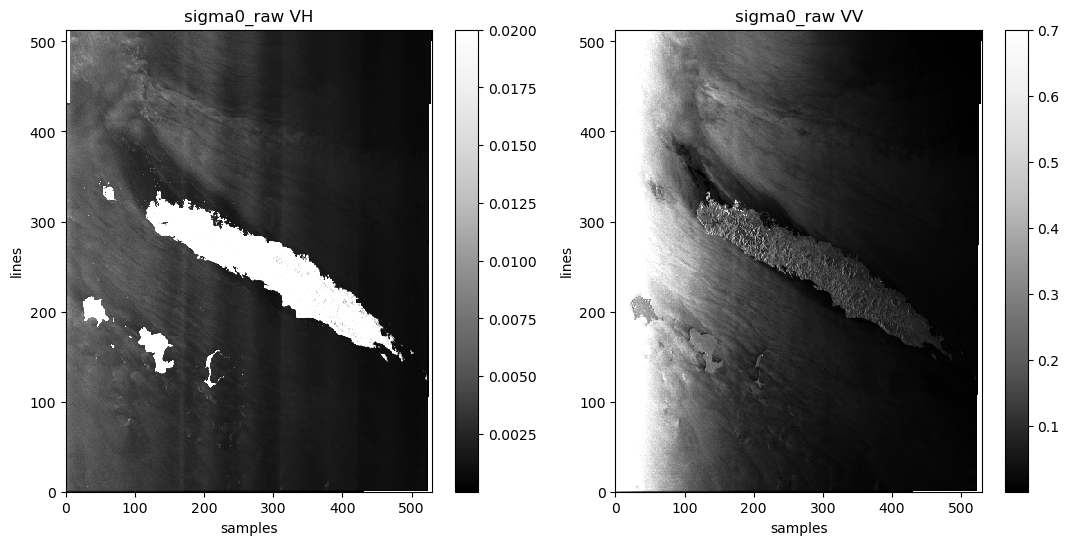

In [125]:
plt.figure(figsize=(13, 6)) 

plt.subplot(1, 2, 1)
sigma0_raw_cross = sigma0_raw.sel(pol='VH')
plt.pcolor(sigma0_raw_cross, vmax=0.02, cmap='Greys_r')
plt.title('sigma0_raw VH')
plt.xlabel('samples')
plt.ylabel('lines')
plt.colorbar()

plt.subplot(1, 2, 2)
sigma0_raw_co = sigma0_raw.sel(pol='VV')
plt.pcolor(sigma0_raw_co, vmax=0.7, cmap='Greys_r')
plt.title('sigma0_raw VV')
plt.xlabel('samples')
plt.ylabel('lines')
plt.colorbar()

## How to apply denoising ?

All the operation below are already performed by default for GRD products. So, what is following is a simple explanation about how is made denoising.

### How to get the Noise Equivalent Sigma Zero ?

`NoiseLevelValues` at low resolution are extracted from product.xml and then located in the datatree of the metadata (`dt['radarParameters']`). They are already calibrated so we don't have to apply a calibration on theseThey are expressed in `dB`, and are given with a `pixelFirstNoiseValue` and a `stepSize`.
With these information we have now to build the `noise_lut`. The first thing to do is to convert the NoiseLevelValues in linear : 

$$ linearNoiseLevelValues = 10^\frac{dBNoiseLevelValues}{10} $$

Right now we compute the nesz thanks to the following documentation : https://earth.esa.int/eogateway/documents/20142/0/Radarsat-2-Product-Format-Definition.pdf/1ca0cf1e-5a15-a29b-6187-9e5cb1650048#page=70

In [ ]:
nesz_low_res = rs2ds._interpolate_for_noise_lut('sigma0')
nesz_low_res

In [ ]:
plt.pcolor(nesz_low_res, vmax=0.005, cmap='Greys_r')
plt.title('nesz')
plt.xlabel('samples')
plt.ylabel('lines')
plt.colorbar()

### How to get the noise substracted Sigma0

Right now we only have to substract the noise_lut to the raw normalized radar cross section. It is made with the function `_add_denoised`, that add the variables to the `RadarSat2Dataset.dataset`

In [124]:
sigma0 = sigma0_raw - nesz_low_res
sigma0

<xarray.DataArray (pol: 2, line: 513, sample: 530)>
dask.array<sub, shape=(2, 513, 530), dtype=float64, chunksize=(1, 513, 530), chunktype=numpy.ndarray>
Coordinates:
  * line     (line) float64 9.5 29.5 49.5 69.5 ... 1.021e+04 1.023e+04 1.025e+04
  * sample   (sample) float64 9.5 29.5 49.5 ... 1.055e+04 1.057e+04 1.059e+04
  * pol      (pol) <U2 'VV' 'VH'

### Comparison between noised sigma0 and noised substracted sigma0

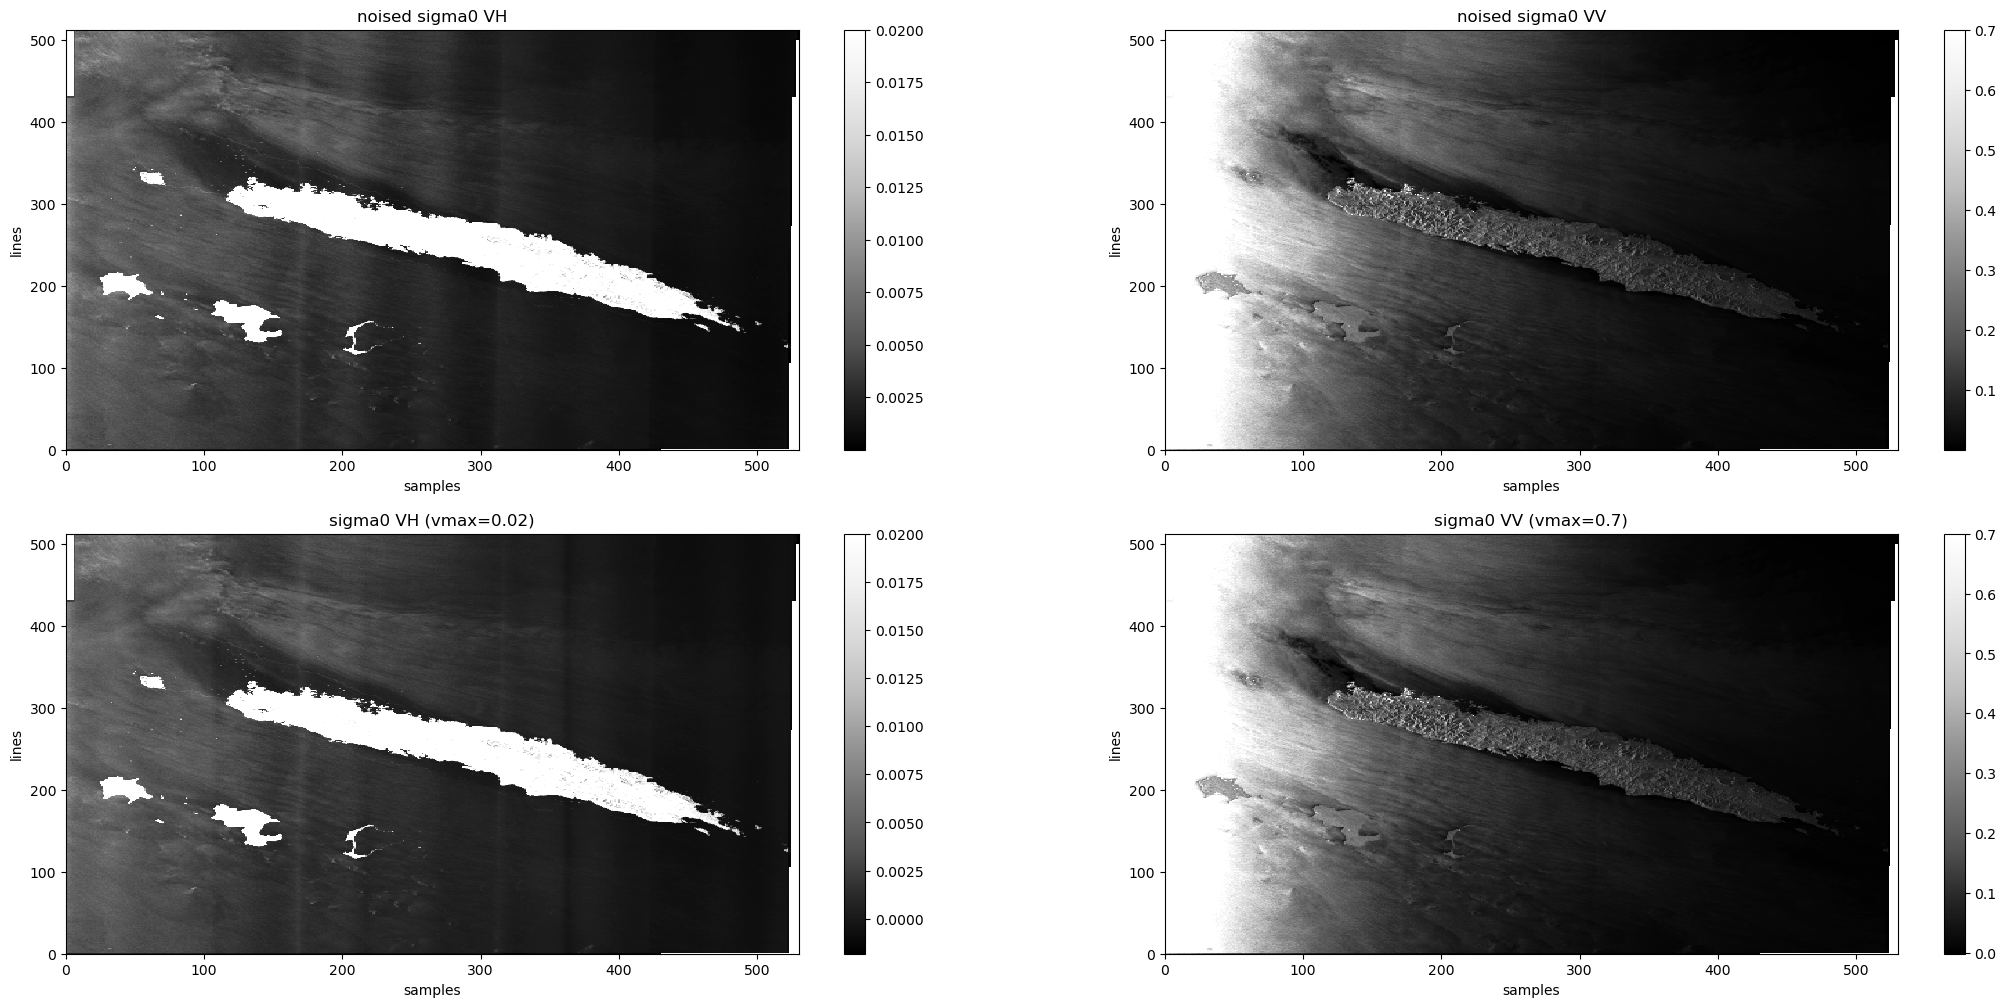

In [128]:
plt.figure(figsize=(26, 12))

sigma0_cross = sigma0.sel(pol='VH')
sigma0_co = sigma0.sel(pol='VV')

plt.subplot(2,2,1)
plt.pcolor(sigma0_raw_cross, vmax=0.02, cmap='Greys_r')
plt.title('noised sigma0 VH')
plt.xlabel('samples')
plt.ylabel('lines')
plt.colorbar()

plt.subplot(2,2,3)
plt.pcolor(sigma0_cross, vmax=0.02, cmap='Greys_r')
plt.title('sigma0 VH (vmax=0.02)')
plt.xlabel('samples')
plt.ylabel('lines')
plt.colorbar()

plt.subplot(2,2,2)
plt.pcolor(sigma0_raw_co, vmax=0.7, cmap='Greys_r')
plt.title('noised sigma0 VV')
plt.xlabel('samples')
plt.ylabel('lines')
plt.colorbar()

plt.subplot(2,2,4)
plt.pcolor(sigma0_co, vmax=0.7, cmap='Greys_r')
plt.title('sigma0 VV (vmax=0.7)')
plt.xlabel('samples')
plt.ylabel('lines')
plt.colorbar()

## How to get the incidence ?

Radarsat2 product format definition (7.2) provides a formula of look up tables, depending on the incidence. We already have information about look up tables, so we determine incidence with these look up tables: 

$$ Incidence = \arctan{\frac{\gamma}{\beta}} $$

reference link : https://earth.esa.int/eogateway/documents/20142/0/Radarsat-2-Product-Format-Definition.pdf/1ca0cf1e-5a15-a29b-6187-9e5cb1650048#page=78

We have the choice between 2 types of look up tables: denoised and not denoised. We have chosen to determine incidence with not denoised look up tables.
This computation is made by the function `_load_incidence_from_lut` that returns a DatArray

In [ ]:
incidence = rs2ds._load_incidence_from_lut()
incidence

## How to get the elevation ?

To get the incidence, we apply a formula :
    
$$\theta = \arcsin{[\sin{(Incidence)} . \frac{r}{r + h}]}$$

( r is the earth radius, h is the orbit altitude )

Reference : Data Products Specifications (https://asf.alaska.edu/wp-content/uploads/2019/03/r1_prod_spec.pdf#page=47)

2 variables look like orbit altitude so we considered the`SatelliteHeight` (and not the`altitude`).
`RadarSat2Dataset._load_elevation_from_lut` permit to calculate the elevation (in degrees).

In [ ]:
elevation = rs2ds._load_elevation_from_lut()
elevation